# JointMatch SSL with EfficientNet on Tiny ImageNet

This notebook implements a Semi-Supervised Learning (SSL) strategy based on JointMatch, using an EfficientNet backbone trained on the Tiny ImageNet dataset. It incorporates concepts like adaptive thresholds, cross-labeling, and weighted disagreement updates.

**References:**
*   JointMatch Paper: [https://arxiv.org/abs/2310.15335](https://arxiv.org/abs/2310.15335) (Although the paper focuses on text, the core SSL ideas are adapted here for images).
*   FixMatch Paper (related baseline): [https://arxiv.org/abs/2001.07685](https://arxiv.org/abs/2001.07685)
*   EfficientNet-PyTorch: [https://github.com/lukemelas/EfficientNet-PyTorch](https://github.com/lukemelas/EfficientNet-PyTorch)

In [1]:
# 1. Install Necessary Packages
# Make sure efficientnet-pytorch is included
!pip install numpy torch torchvision pytorch-ignite tensorboardX tensorboard opendatasets efficientnet-pytorch tqdm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0393027e74a7715f4a84d8351737ff0f780827553a6067277687433d144dd78f
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet-pyt

In [2]:
# 2. Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import os
from random import randint
import urllib
import zipfile
import time
from tqdm.notebook import tqdm

import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchvision.utils import make_grid
from torchvision import models, datasets
from torchvision import transforms as T
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

# EfficientNet
from efficientnet_pytorch import EfficientNet

# Ignite (though we'll use a manual loop for more control over SSL specifics)
# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss
# from ignite.handlers import ModelCheckpoint, global_step_from_engine
# from ignite.contrib.handlers import ProgressBar, TensorboardLogger

# Define device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 3. Download and Prepare Tiny ImageNet Data
if not os.path.exists('tiny-imagenet-200.zip'):
    print("Downloading Tiny ImageNet...")
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
else:
    print("Zip file already downloaded.")

if not os.path.exists('tiny-imagenet-200'):
    print("Unzipping Tiny ImageNet...")
    !unzip -qq 'tiny-imagenet-200.zip'
    print("Unzipping complete.")
else:
    print("Dataset already unzipped.")

DATA_DIR = 'tiny-imagenet-200'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')

# --- Validation Set Reorganization (Run only once) ---
val_anno_file = os.path.join(VALID_DIR, 'val_annotations.txt')
if os.path.exists(val_anno_file):
    print("Reorganizing validation set...")
    val_data = pd.read_csv(val_anno_file, sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
    val_img_dir = os.path.join(VALID_DIR, 'images')

    # Create dictionary to store img filename and corresponding label
    val_img_dict = {}
    for index, row in val_data.iterrows():
        val_img_dict[row['File']] = row['Class']

    # Create subfolders (if not present) for validation images based on label
    for img, folder in val_img_dict.items():
        newpath = os.path.join(val_img_dir, folder)
        if not os.path.exists(newpath):
            os.makedirs(newpath)

        img_path = os.path.join(val_img_dir, img)
        if os.path.exists(img_path):
            os.rename(img_path, os.path.join(newpath, img))

    # Remove the now empty 'images' folder if it exists and is empty
    # Also remove the annotation file to prevent re-running this block easily
    try:
        os.remove(val_anno_file)
        # Check if val_img_dir contains only directories (our class folders)
        is_empty_of_files = all(os.path.isdir(os.path.join(val_img_dir, entry)) for entry in os.listdir(val_img_dir))
        if is_empty_of_files and not os.listdir(val_img_dir): # Extra check if it became truly empty
             os.rmdir(val_img_dir)
        elif is_empty_of_files: # Contains class folders, which is expected
            print(f"Validation images moved to class folders within {val_img_dir}")
        else: # Contains unexpected files
             print(f"Warning: {val_img_dir} contains unexpected files after reorganization.")

    except OSError as e:
        print(f"Error removing file/dir during reorg cleanup: {e}")
    print("Validation set reorganization complete.")
else:
    print("Validation set likely already reorganized (val_annotations.txt not found).")

# Validation images are now inside VALID_DIR/{class_id}/images/*.JPEG
# Update VALID_DIR path to point to the parent of class folders
# VALID_DIR = os.path.join(VALID_DIR, 'images') # Incorrect: ImageFolder expects root/class/image.jpeg
# Keep VALID_DIR as 'tiny-imagenet-200/val'

# --- Get Class Names (Optional but helpful) ---
class_to_name_dict = {}
try:
    with open(os.path.join(DATA_DIR, 'words.txt'), 'r') as fp:
        data = fp.readlines()
    for line in data:
        words = line.strip('\n').split('\t')
        class_to_name_dict[words[0]] = words[1].split(',')[0]
except FileNotFoundError:
    print("words.txt not found, cannot map class IDs to names.")

--2025-04-13 06:38:42--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-04-13 06:38:42--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  40.1MB/s    in 6.1s    

2025-04-13 06:38:48 (38.7 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Unzipping Tiny ImageNet...
Unzipping complete.
Reorganizing validation set...
Validation images moved to class folders within tiny-imagenet-200/val/images
Validation set reorganiza

## 4. Data Transformations and Augmentations

For SSL (like FixMatch/JointMatch), we need:
1.  **Weak Augmentation:** Standard augmentations (like random crops, flips) applied to unlabeled data to generate pseudo-labels.
2.  **Strong Augmentation:** More aggressive augmentations (like RandAugment) applied to the *same* unlabeled data. The model is trained to predict the pseudo-label (from weak augmentation) even with strong augmentation.
3.  **Evaluation Transform:** A deterministic transform for the validation set (usually center crop).

We'll use a smaller input size (112x112) to manage memory with two models and gradient accumulation.

In [4]:
# ImageNet normalization stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Input size for the model (reduced for memory)
INPUT_SIZE = 112
RESIZE_SIZE = 128

# Weak Augmentation (for generating pseudo-labels and for labeled data training)
weak_transform = T.Compose([
    T.Resize(RESIZE_SIZE),
    T.RandomCrop(INPUT_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Strong Augmentation (for consistency regularization on unlabeled data)
strong_transform = T.Compose([
    T.Resize(RESIZE_SIZE),
    T.RandomCrop(INPUT_SIZE),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=10), # Added RandAugment
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transform for Validation/Evaluation (no random augmentation)
val_transform = T.Compose([
    T.Resize(RESIZE_SIZE),
    T.CenterCrop(INPUT_SIZE),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

## 5. Dataset Splitting and Custom Dataset Classes

We split the training data into a small labeled set and a large unlabeled set.

In [5]:
# --- Helper function to split dataset --- 
def split_dataset(dataset, num_labeled_per_class, num_classes=200):
    targets = np.array(dataset.targets)
    labeled_idx = []
    unlabeled_idx = []

    for c in range(num_classes):
        idx = np.where(targets == c)[0]
        if len(idx) == 0:
            print(f"Warning: No samples found for class {c}")
            continue
        np.random.shuffle(idx)
        # Ensure we don't request more labels than available for a class
        num_labeled_actual = min(num_labeled_per_class, len(idx))
        if num_labeled_actual < num_labeled_per_class:
            print(f"Warning: Class {c} only has {num_labeled_actual} samples, requested {num_labeled_per_class}. Using {num_labeled_actual}.")

        labeled_idx.extend(idx[:num_labeled_actual])
        unlabeled_idx.extend(idx[num_labeled_actual:])

    print(f"Total samples: {len(targets)}")
    print(f"Selected {len(labeled_idx)} labeled samples.")
    print(f"Using {len(unlabeled_idx)} unlabeled samples.")
    return labeled_idx, unlabeled_idx

# --- Custom Dataset Classes --- #

class LabeledDataset(Dataset):
    """Dataset wrapper for labeled data."""
    def __init__(self, dataset, indices, transform):
        # Create a Subset using the provided indices
        self.subset = Subset(dataset, indices)
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # Subset automatically handles the mapping from idx to the original dataset's index
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

class UnlabeledDataset(Dataset):
    """Dataset wrapper for unlabeled data. Returns weakly and strongly augmented views."""
    def __init__(self, dataset, indices, weak_transform, strong_transform):
        self.subset = Subset(dataset, indices)
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, _ = self.subset[idx] # Ignore the label for unlabeled data
        weak_img = self.weak_transform(img)
        strong_img = self.strong_transform(img)
        return weak_img, strong_img

# --- Load the full training dataset (needed for splitting) --- #
print("Loading full training dataset for splitting...")
# Apply a minimal transform initially, real transforms are in the custom datasets
full_train_ds = datasets.ImageFolder(TRAIN_DIR, transform=T.Lambda(lambda x: x))
print(f"Full training dataset loaded with {len(full_train_ds)} samples.")
num_classes = len(full_train_ds.classes)
print(f"Number of classes detected: {num_classes}")

# --- Perform the split --- #
num_labeled_per_class = 10 # Example: use 10 labeled images per class
labeled_indices, unlabeled_indices = split_dataset(full_train_ds, num_labeled_per_class, num_classes)

# --- Create the Labeled and Unlabeled Datasets --- #
labeled_ds = LabeledDataset(full_train_ds, labeled_indices, transform=weak_transform)
unlabeled_ds = UnlabeledDataset(full_train_ds, unlabeled_indices, 
                                  weak_transform=weak_transform, 
                                  strong_transform=strong_transform)

# --- Create the Validation Dataset --- #
val_ds = datasets.ImageFolder(VALID_DIR, transform=val_transform)
print(f"Validation dataset loaded with {len(val_ds)} samples.")

# --- Define Batch Sizes and DataLoaders --- #
# Reduced batch sizes for memory management with two models + grad accum
LABELED_BATCH_SIZE = 32
MU = 1 # Ratio of unlabeled batch size to labeled batch size
UNLABELED_BATCH_SIZE = LABELED_BATCH_SIZE * MU
VAL_BATCH_SIZE = 64 # Can be larger as it's only used during evaluation

# Use num_workers > 0 if not debugging, speeds up data loading
num_workers = 2 if use_cuda else 0

labeled_loader = DataLoader(labeled_ds, 
                          batch_size=LABELED_BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=num_workers, 
                          pin_memory=True,
                          drop_last=True) # Drop last for consistent batch sizes

unlabeled_loader = DataLoader(unlabeled_ds, 
                            batch_size=UNLABELED_BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=num_workers, 
                            pin_memory=True,
                            drop_last=True)

val_loader = DataLoader(val_ds, 
                        batch_size=VAL_BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=num_workers, 
                        pin_memory=True)

print(f"DataLoaders created:")
print(f"  Labeled: {len(labeled_loader)} batches, size {LABELED_BATCH_SIZE}")
print(f"  Unlabeled: {len(unlabeled_loader)} batches, size {UNLABELED_BATCH_SIZE}")
print(f"  Validation: {len(val_loader)} batches, size {VAL_BATCH_SIZE}")

Loading full training dataset for splitting...
Full training dataset loaded with 100000 samples.
Number of classes detected: 200
Total samples: 100000
Selected 2000 labeled samples.
Using 98000 unlabeled samples.
Validation dataset loaded with 10000 samples.
DataLoaders created:
  Labeled: 62 batches, size 32
  Unlabeled: 3062 batches, size 32
  Validation: 157 batches, size 64


## 6. Model Definition (EfficientNet with Checkpointing)

We use two instances of EfficientNet-B0, pretrained on ImageNet. We wrap them in a `CheckpointWrapper` to save memory during training using gradient checkpointing.

In [6]:
# --- Gradient Checkpointing Wrapper --- #
# Helps save memory by trading compute time
class CheckpointWrapper(nn.Module):
    def __init__(self, module):
        super(CheckpointWrapper, self).__init__()
        self.module = module

    def forward(self, x):
        # Checkpointing expects inputs that require grad.
        # If input doesn't, wrap it, but don't make this permanent.
        requires_grad_state = x.requires_grad
        if not requires_grad_state:
             x = x.requires_grad_()
             
        # use_reentrant=False is generally recommended for newer PyTorch versions
        out = checkpoint.checkpoint(self.module, x, use_reentrant=False)
        
        # Restore original requires_grad state if we changed it
        # This might not be strictly necessary depending on subsequent ops,
        # but it's cleaner not to modify the input's state permanently.
        # However, detaching might break grad flow if needed later.
        # Let's rely on the checkpoint function handling it correctly and just return 'out'.
        # if not requires_grad_state:
        #      x.requires_grad_(False) # Revert - careful about side effects
             
        return out

# --- Function to create the EfficientNet model --- #
def get_efficientnet_model(num_classes=200, pretrained=True):
    model_name = 'efficientnet-b0'
    if pretrained:
        print(f"Loading pretrained {model_name}...")
        model = EfficientNet.from_pretrained(model_name)
    else:
        print(f"Loading {model_name} without pretrained weights...")
        model = EfficientNet.from_name(model_name)

    # Replace the classifier layer
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, num_classes)
    print(f"Replaced final layer for {num_classes} classes.")
    return model

# --- Create the two models with checkpointing --- #
print("Creating Model F...")
model_f = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes)).to(device)
print("\nCreating Model G...")
model_g = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes)).to(device)

# --- Optimizers --- #
# Using AdamW which is often preferred for Transformers and modern CNNs
LEARNING_RATE = 1e-4 # Lower learning rate for fine-tuning
WEIGHT_DECAY = 1e-4

optimizer_f = optim.AdamW(model_f.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer_g = optim.AdamW(model_g.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# --- Learning Rate Scheduler (Optional but recommended) --- #
# Cosine annealing is a popular choice
scheduler_f = optim.lr_scheduler.CosineAnnealingLR(optimizer_f, T_max=len(labeled_loader) * 100) # T_max = steps per epoch * num_epochs
scheduler_g = optim.lr_scheduler.CosineAnnealingLR(optimizer_g, T_max=len(labeled_loader) * 100)


Creating Model F...
Loading pretrained efficientnet-b0...


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 162MB/s]


Loaded pretrained weights for efficientnet-b0
Replaced final layer for 200 classes.

Creating Model G...
Loading pretrained efficientnet-b0...
Loaded pretrained weights for efficientnet-b0
Replaced final layer for 200 classes.


## 7. JointMatch Training Setup

Define hyperparameters and initialize necessary components for the JointMatch algorithm.

In [7]:
# --- JointMatch Hyperparameters --- #
W_U = 1.0             # Unsupervised loss weight (lambda_u in FixMatch/JointMatch)
EMA_DECAY = 0.99      # Exponential Moving Average decay for class probability estimates
FIXED_TAU = 0.95      # Fixed confidence threshold (base value)
DELTA = 0.9           # Disagreement weight (controls emphasis on disagreement vs agreement)
NUM_EPOCHS = 100      # Total training epochs
MAX_GRAD_NORM = 1.0   # Gradient clipping threshold

# --- Gradient Accumulation --- #
# Accumulate gradients over N steps before optimizer step
# Reduces memory usage at the cost of slower effective batch updates
ACCUMULATION_STEPS = 8 # Adjust based on GPU memory (effective batch size = BATCH_SIZE * ACCUMULATION_STEPS)
print(f"Gradient Accumulation Steps: {ACCUMULATION_STEPS}")
print(f"Effective Labeled Batch Size: {LABELED_BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"Effective Unlabeled Batch Size: {UNLABELED_BATCH_SIZE * ACCUMULATION_STEPS}")

# --- Automatic Mixed Precision (AMP) Scalers --- #
# Use 'enabled=use_cuda' to automatically disable AMP on CPU
scaler_f = torch.cuda.amp.GradScaler(enabled=use_cuda)
scaler_g = torch.cuda.amp.GradScaler(enabled=use_cuda)

# --- EMA for Class Predictions (p_tilde) --- #
# Initialize average predicted probability per class uniformly
# Used for adaptive threshold calculation
p_tilde_f = torch.ones(num_classes, device=device) / num_classes
p_tilde_g = torch.ones(num_classes, device=device) / num_classes

# --- Checkpoint Directory --- #
CHECKPOINT_DIR = "jointmatch_efficientnet_checkpoints"
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
    print(f"Created checkpoint directory: {CHECKPOINT_DIR}")

# --- Metrics Storage --- #
train_losses_sup_f = []
train_losses_sup_g = []
train_losses_unsup_f = []
train_losses_unsup_g = []
train_losses_total_f = []
train_losses_total_g = []
val_accuracies_f = []
val_accuracies_g = []
val_accuracies_avg = []
best_val_acc_avg = 0.0

Gradient Accumulation Steps: 8
Effective Labeled Batch Size: 256
Effective Unlabeled Batch Size: 256
Created checkpoint directory: jointmatch_efficientnet_checkpoints


/tmp/ipykernel_19/1301943766.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_f = torch.cuda.amp.GradScaler(enabled=use_cuda)
/tmp/ipykernel_19/1301943766.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_g = torch.cuda.amp.GradScaler(enabled=use_cuda)


## 8. Evaluation Function

In [8]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Use AMP for evaluation inference as well (can speed things up)
            with torch.amp.autocast(device_type=device.type, enabled=use_cuda):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
            pbar.set_postfix(acc=f"{(correct/total)*100:.2f}%")
            
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

## 9. JointMatch Training Loop

In [9]:
# --- Loss Function (standard Cross Entropy) --- #
ce_loss = nn.CrossEntropyLoss()
ce_loss_reduction_none = nn.CrossEntropyLoss(reduction='none') # For manual weighting

# --- Training Loop --- #
print("Starting JointMatch Training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    model_f.train()
    model_g.train()
    
    # Use iterators for flexibility with different dataset lengths
    labeled_iter = iter(labeled_loader)
    unlabeled_iter = iter(unlabeled_loader)
    
    # Determine number of steps based on the longer loader (usually unlabeled if mu > 1)
    # Since mu=1 and drop_last=True, they have the same length here.
    num_steps = len(labeled_loader) 
    
    running_loss_sup_f, running_loss_unsup_f, running_loss_total_f = 0.0, 0.0, 0.0
    running_loss_sup_g, running_loss_unsup_g, running_loss_total_g = 0.0, 0.0, 0.0
    pseudo_labels_used_f, pseudo_labels_correct_f = 0, 0  # Track pseudo-label stats (optional)
    pseudo_labels_used_g, pseudo_labels_correct_g = 0, 0
    mask_sum_f, mask_sum_g = 0, 0

    # Manually handle optimizer zero_grad with accumulation
    optimizer_f.zero_grad()
    optimizer_g.zero_grad()
    
    pbar = tqdm(range(num_steps), desc=f"Epoch {epoch+1} Training")
    
    for step in pbar:
        try:
            l_imgs, labels = next(labeled_iter)
        except StopIteration:
            # Should not happen with drop_last=True and equal lengths
            labeled_iter = iter(labeled_loader)
            l_imgs, labels = next(labeled_iter)
            
        try:
            weak_imgs, strong_imgs = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            weak_imgs, strong_imgs = next(unlabeled_iter)
            
        l_imgs, labels = l_imgs.to(device), labels.to(device)
        weak_imgs, strong_imgs = weak_imgs.to(device), strong_imgs.to(device)
        
        # Forward passes with AMP context manager
        with torch.amp.autocast(device_type=device.type, enabled=use_cuda):
            # 1. Supervised Loss (Labeled Data)
            logits_f_sup = model_f(l_imgs)
            logits_g_sup = model_g(l_imgs)
            sup_loss_f = ce_loss(logits_f_sup, labels)
            sup_loss_g = ce_loss(logits_g_sup, labels)
            
            # 2. Pseudo-Label Generation (Unlabeled Data - Weak Augmentation)
            # No gradient needed for pseudo-label generation
            with torch.no_grad():
                logits_f_weak = model_f(weak_imgs)
                logits_g_weak = model_g(weak_imgs)
                probs_f_weak = F.softmax(logits_f_weak, dim=1)
                probs_g_weak = F.softmax(logits_g_weak, dim=1)
                
                # Update EMA of class probabilities (p_tilde)
                # Detach probabilities before EMA update
                p_tilde_f = EMA_DECAY * p_tilde_f + (1 - EMA_DECAY) * probs_f_weak.mean(dim=0).detach()
                p_tilde_g = EMA_DECAY * p_tilde_g + (1 - EMA_DECAY) * probs_g_weak.mean(dim=0).detach()
                
                # Calculate Adaptive Thresholds (tau_t)
                # Clamp to avoid division by zero if max is 0 (unlikely with EMA)
                tau_t_f = FIXED_TAU * (p_tilde_f / torch.max(p_tilde_f, torch.tensor(1e-6).to(device)))
                tau_t_g = FIXED_TAU * (p_tilde_g / torch.max(p_tilde_g, torch.tensor(1e-6).to(device)))
                
                # Generate Pseudo-Labels and Masks (Cross-Labeling)
                # Model F uses pseudo-labels from Model G
                max_probs_g, pseudo_labels_g = torch.max(probs_g_weak, dim=1)
                thresholds_g = tau_t_g[pseudo_labels_g] # Get threshold for the predicted class
                mask_f = max_probs_g.ge(thresholds_g)   # Mask where confidence >= threshold
                
                # Model G uses pseudo-labels from Model F
                max_probs_f, pseudo_labels_f = torch.max(probs_f_weak, dim=1)
                thresholds_f = tau_t_f[pseudo_labels_f]
                mask_g = max_probs_f.ge(thresholds_f)
                
                # Disagreement Weights (w_b in paper notation)
                pred_f_hard = torch.argmax(probs_f_weak, dim=1)
                pred_g_hard = torch.argmax(probs_g_weak, dim=1)
                
                disagreement_mask = pred_f_hard.ne(pred_g_hard)
                agreement_mask = pred_f_hard.eq(pred_g_hard)
                
                # Weights for model F's unsupervised loss (using G's pseudo-labels)
                weights_f = torch.where(disagreement_mask, 
                                        torch.tensor(DELTA, device=device), 
                                        torch.tensor(1 - DELTA, device=device))
                                        
                # Weights for model G's unsupervised loss (using F's pseudo-labels)
                weights_g = torch.where(disagreement_mask, 
                                        torch.tensor(DELTA, device=device), 
                                        torch.tensor(1 - DELTA, device=device))

            # 3. Unsupervised Loss (Unlabeled Data - Strong Augmentation)
            logits_f_strong = model_f(strong_imgs)
            logits_g_strong = model_g(strong_imgs)
            
            # Calculate unsupervised loss for model F (using G's labels)
            if mask_f.sum() > 0:
                unsup_loss_f_elementwise = ce_loss_reduction_none(logits_f_strong[mask_f], pseudo_labels_g[mask_f])
                unsup_loss_f = (weights_f[mask_f] * unsup_loss_f_elementwise).mean()
            else:
                unsup_loss_f = torch.tensor(0.0, device=device)
                
            # Calculate unsupervised loss for model G (using F's labels)
            if mask_g.sum() > 0:
                unsup_loss_g_elementwise = ce_loss_reduction_none(logits_g_strong[mask_g], pseudo_labels_f[mask_g])
                unsup_loss_g = (weights_g[mask_g] * unsup_loss_g_elementwise).mean()
            else:
                unsup_loss_g = torch.tensor(0.0, device=device)
                
            # 4. Total Loss
            # Normalize by accumulation steps to keep loss magnitude consistent
            total_loss_f = (sup_loss_f + W_U * unsup_loss_f) / ACCUMULATION_STEPS
            total_loss_g = (sup_loss_g + W_U * unsup_loss_g) / ACCUMULATION_STEPS
            
        # Backward pass with scaler for AMP
        # Check for non-finite losses before backward
        if not torch.isfinite(total_loss_f) or not torch.isfinite(total_loss_g):
            print(f"\nWarning: Non-finite loss detected at Epoch {epoch+1}, Step {step+1}. Skipping step.")
            print(f"Loss F: {total_loss_f.item()}, Loss G: {total_loss_g.item()}")
            # Need to zero grads accumulated so far for this step if skipping
            optimizer_f.zero_grad()
            optimizer_g.zero_grad()
            continue
            
        scaler_f.scale(total_loss_f).backward()
        scaler_g.scale(total_loss_g).backward()
        
        # Accumulate running losses (use original scale)
        running_loss_sup_f += sup_loss_f.item() 
        running_loss_unsup_f += unsup_loss_f.item()
        running_loss_total_f += total_loss_f.item() * ACCUMULATION_STEPS # Multiply back accum steps
        running_loss_sup_g += sup_loss_g.item()
        running_loss_unsup_g += unsup_loss_g.item()
        running_loss_total_g += total_loss_g.item() * ACCUMULATION_STEPS
        mask_sum_f += mask_f.float().sum().item()
        mask_sum_g += mask_g.float().sum().item()

        # --- Optimizer Step after Accumulation --- #
        if (step + 1) % ACCUMULATION_STEPS == 0:
            # Unscale gradients and clip
            scaler_f.unscale_(optimizer_f)
            torch.nn.utils.clip_grad_norm_(model_f.parameters(), MAX_GRAD_NORM)
            scaler_g.unscale_(optimizer_g)
            torch.nn.utils.clip_grad_norm_(model_g.parameters(), MAX_GRAD_NORM)
            
            # Optimizer step
            scaler_f.step(optimizer_f)
            scaler_g.step(optimizer_g)
            
            # Update scaler
            scaler_f.update()
            scaler_g.update()
            
            # Zero gradients for the next accumulation cycle
            optimizer_f.zero_grad()
            optimizer_g.zero_grad()

            # Step LR scheduler (optional, depends on schedule type)
            # If using CosineAnnealingLR, step every optimizer step
            if scheduler_f: scheduler_f.step()
            if scheduler_g: scheduler_g.step()
                
        # Update progress bar
        pbar.set_postfix(loss_f=f"{total_loss_f.item()*ACCUMULATION_STEPS:.3f}", 
                         loss_g=f"{total_loss_g.item()*ACCUMULATION_STEPS:.3f}", 
                         mask_f=f"{mask_f.float().mean().item():.2f}",
                         mask_g=f"{mask_g.float().mean().item():.2f}",
                         lr_f=f"{optimizer_f.param_groups[0]['lr']:.1E}",
                         lr_g=f"{optimizer_g.param_groups[0]['lr']:.1E}")
        
        # Clean up memory
        del l_imgs, labels, weak_imgs, strong_imgs, logits_f_sup, logits_g_sup, \
            logits_f_weak, logits_g_weak, probs_f_weak, probs_g_weak, \
            logits_f_strong, logits_g_strong, sup_loss_f, sup_loss_g, unsup_loss_f, unsup_loss_g, \
            total_loss_f, total_loss_g, mask_f, mask_g, weights_f, weights_g
        if use_cuda: torch.cuda.empty_cache()

    # --- End of Epoch --- #
    epoch_duration = time.time() - epoch_start_time
    
    # Calculate average losses for the epoch
    avg_loss_sup_f = running_loss_sup_f / num_steps
    avg_loss_unsup_f = running_loss_unsup_f / num_steps if mask_sum_f > 0 else 0
    avg_loss_total_f = running_loss_total_f / num_steps
    avg_loss_sup_g = running_loss_sup_g / num_steps
    avg_loss_unsup_g = running_loss_unsup_g / num_steps if mask_sum_g > 0 else 0
    avg_loss_total_g = running_loss_total_g / num_steps
    avg_mask_f = mask_sum_f / (num_steps * UNLABELED_BATCH_SIZE)
    avg_mask_g = mask_sum_g / (num_steps * UNLABELED_BATCH_SIZE)
    
    train_losses_sup_f.append(avg_loss_sup_f)
    train_losses_unsup_f.append(avg_loss_unsup_f)
    train_losses_total_f.append(avg_loss_total_f)
    train_losses_sup_g.append(avg_loss_sup_g)
    train_losses_unsup_g.append(avg_loss_unsup_g)
    train_losses_total_g.append(avg_loss_total_g)
    
    print(f"Epoch {epoch+1} Summary:")
    print(f"  Duration: {epoch_duration:.2f}s")
    print(f"  Avg Loss F: Total={avg_loss_total_f:.4f} (Sup={avg_loss_sup_f:.4f}, Unsup={avg_loss_unsup_f:.4f}) Mask={avg_mask_f:.3f}")
    print(f"  Avg Loss G: Total={avg_loss_total_g:.4f} (Sup={avg_loss_sup_g:.4f}, Unsup={avg_loss_unsup_g:.4f}) Mask={avg_mask_g:.3f}")
    
    # Evaluate on validation set
    print("Evaluating Model F...")
    val_loss_f, val_acc_f = evaluate(model_f, val_loader, ce_loss)
    print(f"  Model F Val Loss: {val_loss_f:.4f}, Val Acc: {val_acc_f*100:.2f}%")
    print("Evaluating Model G...")
    val_loss_g, val_acc_g = evaluate(model_g, val_loader, ce_loss)
    print(f"  Model G Val Loss: {val_loss_g:.4f}, Val Acc: {val_acc_g*100:.2f}%")
    
    val_accuracies_f.append(val_acc_f)
    val_accuracies_g.append(val_acc_g)
    avg_val_acc = (val_acc_f + val_acc_g) / 2.0
    val_accuracies_avg.append(avg_val_acc)
    print(f"  Average Val Acc: {avg_val_acc*100:.2f}%")

    # Save checkpoint (best model based on average accuracy)
    if avg_val_acc > best_val_acc_avg:
        best_val_acc_avg = avg_val_acc
        torch.save(model_f.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model_f.pt"))
        torch.save(model_g.state_dict(), os.path.join(CHECKPOINT_DIR, "best_model_g.pt"))
        torch.save(optimizer_f.state_dict(), os.path.join(CHECKPOINT_DIR, "best_optimizer_f.pt"))
        torch.save(optimizer_g.state_dict(), os.path.join(CHECKPOINT_DIR, "best_optimizer_g.pt"))
        if scheduler_f: torch.save(scheduler_f.state_dict(), os.path.join(CHECKPOINT_DIR, "best_scheduler_f.pt"))
        if scheduler_g: torch.save(scheduler_g.state_dict(), os.path.join(CHECKPOINT_DIR, "best_scheduler_g.pt"))
        print(f"*** New best average validation accuracy: {avg_val_acc*100:.2f}%. Best models saved. ***")
    
    # Save checkpoint for the current epoch
    epoch_save_path_f = os.path.join(CHECKPOINT_DIR, f"model_f_epoch{epoch+1}.pt")
    epoch_save_path_g = os.path.join(CHECKPOINT_DIR, f"model_g_epoch{epoch+1}.pt")
    torch.save(model_f.state_dict(), epoch_save_path_f)
    torch.save(model_g.state_dict(), epoch_save_path_g)
    # print(f"Epoch {epoch+1} models saved to {epoch_save_path_f} and {epoch_save_path_g}")

    if use_cuda: torch.cuda.empty_cache()

total_training_time = time.time() - start_time
print(f"\n--- Training Finished --- ")
print(f"Total Training Time: {total_training_time/3600:.2f} hours")
print(f"Best Average Validation Accuracy: {best_val_acc_avg*100:.2f}%")

Starting JointMatch Training...

--- Epoch 1/100 ---


Epoch 1 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1 Summary:
  Duration: 21.43s
  Avg Loss F: Total=5.3197 (Sup=5.3197, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.3238 (Sup=5.3238, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3693, Val Acc: 0.31%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.2863, Val Acc: 0.62%
  Average Val Acc: 0.46%
*** New best average validation accuracy: 0.46%. Best models saved. ***

--- Epoch 2/100 ---


Epoch 2 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2 Summary:
  Duration: 19.24s
  Avg Loss F: Total=5.2393 (Sup=5.2393, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.2404 (Sup=5.2404, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3718, Val Acc: 0.29%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3047, Val Acc: 0.41%
  Average Val Acc: 0.35%

--- Epoch 3/100 ---


Epoch 3 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3 Summary:
  Duration: 19.38s
  Avg Loss F: Total=5.1646 (Sup=5.1646, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.1681 (Sup=5.1681, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3793, Val Acc: 0.25%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3155, Val Acc: 0.34%
  Average Val Acc: 0.29%

--- Epoch 4/100 ---


Epoch 4 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4 Summary:
  Duration: 19.24s
  Avg Loss F: Total=5.0917 (Sup=5.0917, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.0933 (Sup=5.0933, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3863, Val Acc: 0.23%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3163, Val Acc: 0.31%
  Average Val Acc: 0.27%

--- Epoch 5/100 ---


Epoch 5 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5 Summary:
  Duration: 18.95s
  Avg Loss F: Total=5.0184 (Sup=5.0184, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=5.0188 (Sup=5.0188, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3953, Val Acc: 0.28%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3243, Val Acc: 0.31%
  Average Val Acc: 0.29%

--- Epoch 6/100 ---


Epoch 6 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 6 Summary:
  Duration: 19.08s
  Avg Loss F: Total=4.9430 (Sup=4.9430, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.9464 (Sup=4.9464, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.3896, Val Acc: 0.28%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3277, Val Acc: 0.33%
  Average Val Acc: 0.30%

--- Epoch 7/100 ---


Epoch 7 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 7 Summary:
  Duration: 18.96s
  Avg Loss F: Total=4.8726 (Sup=4.8726, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.8714 (Sup=4.8714, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4051, Val Acc: 0.30%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3344, Val Acc: 0.33%
  Average Val Acc: 0.32%

--- Epoch 8/100 ---


Epoch 8 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 8 Summary:
  Duration: 19.09s
  Avg Loss F: Total=4.7664 (Sup=4.7664, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.7789 (Sup=4.7789, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4112, Val Acc: 0.33%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3331, Val Acc: 0.32%
  Average Val Acc: 0.33%

--- Epoch 9/100 ---


Epoch 9 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 9 Summary:
  Duration: 19.20s
  Avg Loss F: Total=4.6937 (Sup=4.6937, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.6964 (Sup=4.6964, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4216, Val Acc: 0.31%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3390, Val Acc: 0.32%
  Average Val Acc: 0.32%

--- Epoch 10/100 ---


Epoch 10 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 10 Summary:
  Duration: 19.10s
  Avg Loss F: Total=4.6007 (Sup=4.6007, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.6068 (Sup=4.6068, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4237, Val Acc: 0.37%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3401, Val Acc: 0.36%
  Average Val Acc: 0.36%

--- Epoch 11/100 ---


Epoch 11 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 11 Summary:
  Duration: 18.95s
  Avg Loss F: Total=4.5112 (Sup=4.5112, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.5135 (Sup=4.5135, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4436, Val Acc: 0.34%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3474, Val Acc: 0.47%
  Average Val Acc: 0.40%

--- Epoch 12/100 ---


Epoch 12 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 12 Summary:
  Duration: 19.14s
  Avg Loss F: Total=4.4168 (Sup=4.4168, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.4179 (Sup=4.4179, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4724, Val Acc: 0.42%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3542, Val Acc: 0.53%
  Average Val Acc: 0.47%
*** New best average validation accuracy: 0.47%. Best models saved. ***

--- Epoch 13/100 ---


Epoch 13 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 13 Summary:
  Duration: 18.89s
  Avg Loss F: Total=4.2931 (Sup=4.2931, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.3036 (Sup=4.3036, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4818, Val Acc: 0.44%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3691, Val Acc: 0.53%
  Average Val Acc: 0.48%
*** New best average validation accuracy: 0.48%. Best models saved. ***

--- Epoch 14/100 ---


Epoch 14 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 14 Summary:
  Duration: 19.26s
  Avg Loss F: Total=4.1966 (Sup=4.1966, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.2000 (Sup=4.2000, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.4992, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3720, Val Acc: 0.62%
  Average Val Acc: 0.57%
*** New best average validation accuracy: 0.57%. Best models saved. ***

--- Epoch 15/100 ---


Epoch 15 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 15 Summary:
  Duration: 19.02s
  Avg Loss F: Total=4.0722 (Sup=4.0722, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=4.0923 (Sup=4.0923, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.5284, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3836, Val Acc: 0.62%
  Average Val Acc: 0.57%

--- Epoch 16/100 ---


Epoch 16 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 16 Summary:
  Duration: 19.18s
  Avg Loss F: Total=3.9788 (Sup=3.9788, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.9738 (Sup=3.9738, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.5597, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.3929, Val Acc: 0.65%
  Average Val Acc: 0.58%
*** New best average validation accuracy: 0.58%. Best models saved. ***

--- Epoch 17/100 ---


Epoch 17 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 17 Summary:
  Duration: 19.02s
  Avg Loss F: Total=3.8595 (Sup=3.8595, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.8666 (Sup=3.8666, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.5809, Val Acc: 0.57%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4146, Val Acc: 0.63%
  Average Val Acc: 0.60%
*** New best average validation accuracy: 0.60%. Best models saved. ***

--- Epoch 18/100 ---


Epoch 18 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 18 Summary:
  Duration: 18.96s
  Avg Loss F: Total=3.7450 (Sup=3.7450, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.7613 (Sup=3.7613, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.6089, Val Acc: 0.60%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4240, Val Acc: 0.67%
  Average Val Acc: 0.64%
*** New best average validation accuracy: 0.64%. Best models saved. ***

--- Epoch 19/100 ---


Epoch 19 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 19 Summary:
  Duration: 19.02s
  Avg Loss F: Total=3.6385 (Sup=3.6385, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.6472 (Sup=3.6472, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.6456, Val Acc: 0.62%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4452, Val Acc: 0.70%
  Average Val Acc: 0.66%
*** New best average validation accuracy: 0.66%. Best models saved. ***

--- Epoch 20/100 ---


Epoch 20 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 20 Summary:
  Duration: 18.97s
  Avg Loss F: Total=3.5062 (Sup=3.5062, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.5348 (Sup=3.5348, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.6983, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.4885, Val Acc: 0.65%
  Average Val Acc: 0.60%

--- Epoch 21/100 ---


Epoch 21 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 21 Summary:
  Duration: 19.28s
  Avg Loss F: Total=3.4074 (Sup=3.4074, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.4184 (Sup=3.4184, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.7456, Val Acc: 0.58%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5214, Val Acc: 0.67%
  Average Val Acc: 0.62%

--- Epoch 22/100 ---


Epoch 22 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 22 Summary:
  Duration: 19.00s
  Avg Loss F: Total=3.2746 (Sup=3.2746, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.2879 (Sup=3.2879, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.7464, Val Acc: 0.63%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5214, Val Acc: 0.72%
  Average Val Acc: 0.68%
*** New best average validation accuracy: 0.68%. Best models saved. ***

--- Epoch 23/100 ---


Epoch 23 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 23 Summary:
  Duration: 19.13s
  Avg Loss F: Total=3.1520 (Sup=3.1520, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.1797 (Sup=3.1797, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.8042, Val Acc: 0.60%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5803, Val Acc: 0.69%
  Average Val Acc: 0.65%

--- Epoch 24/100 ---


Epoch 24 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 24 Summary:
  Duration: 19.11s
  Avg Loss F: Total=3.0352 (Sup=3.0352, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=3.0697 (Sup=3.0697, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.8233, Val Acc: 0.66%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.5964, Val Acc: 0.71%
  Average Val Acc: 0.69%
*** New best average validation accuracy: 0.69%. Best models saved. ***

--- Epoch 25/100 ---


Epoch 25 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 25 Summary:
  Duration: 19.38s
  Avg Loss F: Total=2.9359 (Sup=2.9359, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.9664 (Sup=2.9664, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.8695, Val Acc: 0.65%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.6353, Val Acc: 0.70%
  Average Val Acc: 0.68%

--- Epoch 26/100 ---


Epoch 26 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 26 Summary:
  Duration: 19.19s
  Avg Loss F: Total=2.8326 (Sup=2.8326, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.8766 (Sup=2.8766, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.9188, Val Acc: 0.63%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.6673, Val Acc: 0.68%
  Average Val Acc: 0.66%

--- Epoch 27/100 ---


Epoch 27 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 27 Summary:
  Duration: 19.15s
  Avg Loss F: Total=2.7114 (Sup=2.7114, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.7445 (Sup=2.7445, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 5.9625, Val Acc: 0.65%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.7001, Val Acc: 0.73%
  Average Val Acc: 0.69%
*** New best average validation accuracy: 0.69%. Best models saved. ***

--- Epoch 28/100 ---


Epoch 28 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 28 Summary:
  Duration: 19.54s
  Avg Loss F: Total=2.5952 (Sup=2.5952, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.6552 (Sup=2.6552, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.0055, Val Acc: 0.60%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.7502, Val Acc: 0.68%
  Average Val Acc: 0.64%

--- Epoch 29/100 ---


Epoch 29 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 29 Summary:
  Duration: 19.53s
  Avg Loss F: Total=2.5075 (Sup=2.5075, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.5525 (Sup=2.5525, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.0585, Val Acc: 0.61%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.8042, Val Acc: 0.69%
  Average Val Acc: 0.65%

--- Epoch 30/100 ---


Epoch 30 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 30 Summary:
  Duration: 20.06s
  Avg Loss F: Total=2.4048 (Sup=2.4048, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.4618 (Sup=2.4615, Unsup=0.0003) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.0959, Val Acc: 0.59%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.8380, Val Acc: 0.67%
  Average Val Acc: 0.63%

--- Epoch 31/100 ---


Epoch 31 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 31 Summary:
  Duration: 19.60s
  Avg Loss F: Total=2.2846 (Sup=2.2846, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.3495 (Sup=2.3495, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.1313, Val Acc: 0.60%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.8873, Val Acc: 0.66%
  Average Val Acc: 0.63%

--- Epoch 32/100 ---


Epoch 32 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 32 Summary:
  Duration: 19.31s
  Avg Loss F: Total=2.1993 (Sup=2.1993, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.2687 (Sup=2.2687, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.1910, Val Acc: 0.58%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.9378, Val Acc: 0.60%
  Average Val Acc: 0.59%

--- Epoch 33/100 ---


Epoch 33 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 33 Summary:
  Duration: 19.44s
  Avg Loss F: Total=2.1056 (Sup=2.1056, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.1745 (Sup=2.1745, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.2082, Val Acc: 0.60%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 5.9432, Val Acc: 0.60%
  Average Val Acc: 0.60%

--- Epoch 34/100 ---


Epoch 34 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 34 Summary:
  Duration: 19.76s
  Avg Loss F: Total=2.0262 (Sup=2.0262, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.0939 (Sup=2.0939, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.2713, Val Acc: 0.57%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.0104, Val Acc: 0.61%
  Average Val Acc: 0.59%

--- Epoch 35/100 ---


Epoch 35 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 35 Summary:
  Duration: 19.15s
  Avg Loss F: Total=1.9292 (Sup=1.9292, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=2.0031 (Sup=2.0031, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.3385, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.0632, Val Acc: 0.56%
  Average Val Acc: 0.56%

--- Epoch 36/100 ---


Epoch 36 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 36 Summary:
  Duration: 19.62s
  Avg Loss F: Total=1.8713 (Sup=1.8713, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.9299 (Sup=1.9299, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.3627, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.0879, Val Acc: 0.58%
  Average Val Acc: 0.57%

--- Epoch 37/100 ---


Epoch 37 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 37 Summary:
  Duration: 19.46s
  Avg Loss F: Total=1.7590 (Sup=1.7590, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.8377 (Sup=1.8377, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.4237, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.1277, Val Acc: 0.57%
  Average Val Acc: 0.56%

--- Epoch 38/100 ---


Epoch 38 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 38 Summary:
  Duration: 19.64s
  Avg Loss F: Total=1.6884 (Sup=1.6884, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.7543 (Sup=1.7543, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.4487, Val Acc: 0.58%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.1761, Val Acc: 0.63%
  Average Val Acc: 0.60%

--- Epoch 39/100 ---


Epoch 39 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 39 Summary:
  Duration: 19.73s
  Avg Loss F: Total=1.5913 (Sup=1.5913, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.6569 (Sup=1.6569, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.5122, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.2247, Val Acc: 0.60%
  Average Val Acc: 0.56%

--- Epoch 40/100 ---


Epoch 40 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 40 Summary:
  Duration: 19.32s
  Avg Loss F: Total=1.5329 (Sup=1.5329, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.5994 (Sup=1.5994, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.5842, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.2836, Val Acc: 0.60%
  Average Val Acc: 0.57%

--- Epoch 41/100 ---


Epoch 41 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 41 Summary:
  Duration: 19.14s
  Avg Loss F: Total=1.4657 (Sup=1.4657, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.5250 (Sup=1.5250, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.6315, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.3235, Val Acc: 0.60%
  Average Val Acc: 0.56%

--- Epoch 42/100 ---


Epoch 42 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 42 Summary:
  Duration: 19.43s
  Avg Loss F: Total=1.4051 (Sup=1.4051, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.4601 (Sup=1.4601, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.6585, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.3383, Val Acc: 0.61%
  Average Val Acc: 0.57%

--- Epoch 43/100 ---


Epoch 43 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 43 Summary:
  Duration: 19.30s
  Avg Loss F: Total=1.2998 (Sup=1.2998, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.3575 (Sup=1.3575, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.6987, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.4079, Val Acc: 0.59%
  Average Val Acc: 0.56%

--- Epoch 44/100 ---


Epoch 44 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 44 Summary:
  Duration: 19.17s
  Avg Loss F: Total=1.2501 (Sup=1.2501, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.3063 (Sup=1.3063, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.7799, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.4957, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 45/100 ---


Epoch 45 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 45 Summary:
  Duration: 19.44s
  Avg Loss F: Total=1.1544 (Sup=1.1544, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.2056 (Sup=1.2056, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.8189, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.5461, Val Acc: 0.57%
  Average Val Acc: 0.54%

--- Epoch 46/100 ---


Epoch 46 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 46 Summary:
  Duration: 19.46s
  Avg Loss F: Total=1.1312 (Sup=1.1307, Unsup=0.0005) Mask=0.001
  Avg Loss G: Total=1.2052 (Sup=1.2041, Unsup=0.0011) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.8094, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.5381, Val Acc: 0.60%
  Average Val Acc: 0.56%

--- Epoch 47/100 ---


Epoch 47 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 47 Summary:
  Duration: 19.36s
  Avg Loss F: Total=1.0744 (Sup=1.0744, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.1179 (Sup=1.1175, Unsup=0.0004) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.8822, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.5879, Val Acc: 0.60%
  Average Val Acc: 0.56%

--- Epoch 48/100 ---


Epoch 48 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 48 Summary:
  Duration: 19.28s
  Avg Loss F: Total=1.0158 (Sup=1.0158, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=1.0651 (Sup=1.0651, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.9058, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.6294, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 49/100 ---


Epoch 49 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 49 Summary:
  Duration: 19.64s
  Avg Loss F: Total=0.9805 (Sup=0.9795, Unsup=0.0010) Mask=0.001
  Avg Loss G: Total=1.0273 (Sup=1.0230, Unsup=0.0043) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 6.9552, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.7004, Val Acc: 0.57%
  Average Val Acc: 0.55%

--- Epoch 50/100 ---


Epoch 50 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 50 Summary:
  Duration: 18.97s
  Avg Loss F: Total=0.9054 (Sup=0.9054, Unsup=0.0000) Mask=0.000
  Avg Loss G: Total=0.9590 (Sup=0.9590, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.0297, Val Acc: 0.49%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.7636, Val Acc: 0.56%
  Average Val Acc: 0.52%

--- Epoch 51/100 ---


Epoch 51 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 51 Summary:
  Duration: 19.69s
  Avg Loss F: Total=0.8816 (Sup=0.8810, Unsup=0.0007) Mask=0.001
  Avg Loss G: Total=0.9284 (Sup=0.9246, Unsup=0.0037) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.0485, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.7922, Val Acc: 0.58%
  Average Val Acc: 0.56%

--- Epoch 52/100 ---


Epoch 52 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 52 Summary:
  Duration: 19.32s
  Avg Loss F: Total=0.8174 (Sup=0.8166, Unsup=0.0008) Mask=0.001
  Avg Loss G: Total=0.8527 (Sup=0.8525, Unsup=0.0002) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.1123, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.8558, Val Acc: 0.59%
  Average Val Acc: 0.56%

--- Epoch 53/100 ---


Epoch 53 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 53 Summary:
  Duration: 19.14s
  Avg Loss F: Total=0.7862 (Sup=0.7855, Unsup=0.0007) Mask=0.001
  Avg Loss G: Total=0.8227 (Sup=0.8227, Unsup=0.0000) Mask=0.000
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.1901, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.9072, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 54/100 ---


Epoch 54 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 54 Summary:
  Duration: 19.94s
  Avg Loss F: Total=0.7722 (Sup=0.7658, Unsup=0.0064) Mask=0.001
  Avg Loss G: Total=0.7814 (Sup=0.7809, Unsup=0.0005) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.2284, Val Acc: 0.49%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 6.9601, Val Acc: 0.51%
  Average Val Acc: 0.50%

--- Epoch 55/100 ---


Epoch 55 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 55 Summary:
  Duration: 19.51s
  Avg Loss F: Total=0.7052 (Sup=0.7033, Unsup=0.0019) Mask=0.002
  Avg Loss G: Total=0.7366 (Sup=0.7358, Unsup=0.0007) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.2426, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.0087, Val Acc: 0.55%
  Average Val Acc: 0.54%

--- Epoch 56/100 ---


Epoch 56 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 56 Summary:
  Duration: 19.58s
  Avg Loss F: Total=0.6703 (Sup=0.6648, Unsup=0.0055) Mask=0.003
  Avg Loss G: Total=0.6884 (Sup=0.6872, Unsup=0.0013) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.3204, Val Acc: 0.48%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.0509, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 57/100 ---


Epoch 57 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 57 Summary:
  Duration: 19.25s
  Avg Loss F: Total=0.6361 (Sup=0.6346, Unsup=0.0015) Mask=0.002
  Avg Loss G: Total=0.6616 (Sup=0.6611, Unsup=0.0005) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.3257, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.0716, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 58/100 ---


Epoch 58 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 58 Summary:
  Duration: 19.70s
  Avg Loss F: Total=0.6172 (Sup=0.6092, Unsup=0.0080) Mask=0.002
  Avg Loss G: Total=0.6344 (Sup=0.6330, Unsup=0.0014) Mask=0.004
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4031, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.1151, Val Acc: 0.55%
  Average Val Acc: 0.54%

--- Epoch 59/100 ---


Epoch 59 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 59 Summary:
  Duration: 20.30s
  Avg Loss F: Total=0.5880 (Sup=0.5810, Unsup=0.0070) Mask=0.005
  Avg Loss G: Total=0.6164 (Sup=0.6088, Unsup=0.0076) Mask=0.005
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4065, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.1515, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 60/100 ---


Epoch 60 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 60 Summary:
  Duration: 19.96s
  Avg Loss F: Total=0.5350 (Sup=0.5313, Unsup=0.0037) Mask=0.003
  Avg Loss G: Total=0.5542 (Sup=0.5526, Unsup=0.0016) Mask=0.002
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4419, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.1769, Val Acc: 0.59%
  Average Val Acc: 0.57%

--- Epoch 61/100 ---


Epoch 61 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 61 Summary:
  Duration: 19.92s
  Avg Loss F: Total=0.5101 (Sup=0.5082, Unsup=0.0019) Mask=0.003
  Avg Loss G: Total=0.5338 (Sup=0.5334, Unsup=0.0004) Mask=0.001
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.4989, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.2345, Val Acc: 0.59%
  Average Val Acc: 0.56%

--- Epoch 62/100 ---


Epoch 62 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 62 Summary:
  Duration: 20.33s
  Avg Loss F: Total=0.4894 (Sup=0.4864, Unsup=0.0030) Mask=0.002
  Avg Loss G: Total=0.5056 (Sup=0.5020, Unsup=0.0036) Mask=0.005
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.5624, Val Acc: 0.49%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.2708, Val Acc: 0.63%
  Average Val Acc: 0.56%

--- Epoch 63/100 ---


Epoch 63 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 63 Summary:
  Duration: 20.69s
  Avg Loss F: Total=0.4695 (Sup=0.4660, Unsup=0.0035) Mask=0.007
  Avg Loss G: Total=0.4826 (Sup=0.4797, Unsup=0.0028) Mask=0.005
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.5818, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.3016, Val Acc: 0.60%
  Average Val Acc: 0.56%

--- Epoch 64/100 ---


Epoch 64 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 64 Summary:
  Duration: 20.08s
  Avg Loss F: Total=0.4446 (Sup=0.4333, Unsup=0.0113) Mask=0.007
  Avg Loss G: Total=0.4532 (Sup=0.4480, Unsup=0.0051) Mask=0.006
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.6479, Val Acc: 0.50%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.3803, Val Acc: 0.60%
  Average Val Acc: 0.55%

--- Epoch 65/100 ---


Epoch 65 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 65 Summary:
  Duration: 20.64s
  Avg Loss F: Total=0.4144 (Sup=0.4029, Unsup=0.0115) Mask=0.007
  Avg Loss G: Total=0.4337 (Sup=0.4272, Unsup=0.0065) Mask=0.008
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.6758, Val Acc: 0.49%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.4055, Val Acc: 0.59%
  Average Val Acc: 0.54%

--- Epoch 66/100 ---


Epoch 66 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 66 Summary:
  Duration: 20.68s
  Avg Loss F: Total=0.3702 (Sup=0.3598, Unsup=0.0104) Mask=0.008
  Avg Loss G: Total=0.4147 (Sup=0.4015, Unsup=0.0132) Mask=0.008
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.7030, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.4305, Val Acc: 0.63%
  Average Val Acc: 0.57%

--- Epoch 67/100 ---


Epoch 67 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 67 Summary:
  Duration: 20.41s
  Avg Loss F: Total=0.3726 (Sup=0.3695, Unsup=0.0030) Mask=0.008
  Avg Loss G: Total=0.3868 (Sup=0.3781, Unsup=0.0087) Mask=0.006
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.7476, Val Acc: 0.47%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.5005, Val Acc: 0.57%
  Average Val Acc: 0.52%

--- Epoch 68/100 ---


Epoch 68 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 68 Summary:
  Duration: 21.12s
  Avg Loss F: Total=0.3644 (Sup=0.3566, Unsup=0.0078) Mask=0.010
  Avg Loss G: Total=0.3843 (Sup=0.3620, Unsup=0.0223) Mask=0.014
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.7814, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.5326, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 69/100 ---


Epoch 69 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 69 Summary:
  Duration: 20.66s
  Avg Loss F: Total=0.3345 (Sup=0.3204, Unsup=0.0140) Mask=0.006
  Avg Loss G: Total=0.3518 (Sup=0.3385, Unsup=0.0134) Mask=0.008
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.8600, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.5906, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 70/100 ---


Epoch 70 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 70 Summary:
  Duration: 20.64s
  Avg Loss F: Total=0.3515 (Sup=0.3325, Unsup=0.0189) Mask=0.008
  Avg Loss G: Total=0.3525 (Sup=0.3449, Unsup=0.0075) Mask=0.010
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.8545, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.6027, Val Acc: 0.58%
  Average Val Acc: 0.56%

--- Epoch 71/100 ---


Epoch 71 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 71 Summary:
  Duration: 21.50s
  Avg Loss F: Total=0.3149 (Sup=0.3043, Unsup=0.0105) Mask=0.011
  Avg Loss G: Total=0.3235 (Sup=0.3112, Unsup=0.0123) Mask=0.015
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.9285, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.6435, Val Acc: 0.57%
  Average Val Acc: 0.55%

--- Epoch 72/100 ---


Epoch 72 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 72 Summary:
  Duration: 21.23s
  Avg Loss F: Total=0.3121 (Sup=0.2887, Unsup=0.0234) Mask=0.011
  Avg Loss G: Total=0.3101 (Sup=0.2919, Unsup=0.0181) Mask=0.014
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.9368, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.6954, Val Acc: 0.57%
  Average Val Acc: 0.55%

--- Epoch 73/100 ---


Epoch 73 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 73 Summary:
  Duration: 21.05s
  Avg Loss F: Total=0.2885 (Sup=0.2729, Unsup=0.0156) Mask=0.011
  Avg Loss G: Total=0.2808 (Sup=0.2690, Unsup=0.0118) Mask=0.009
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 7.9664, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.7179, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 74/100 ---


Epoch 74 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 74 Summary:
  Duration: 21.36s
  Avg Loss F: Total=0.2580 (Sup=0.2495, Unsup=0.0085) Mask=0.015
  Avg Loss G: Total=0.2746 (Sup=0.2666, Unsup=0.0080) Mask=0.013
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.0457, Val Acc: 0.51%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.7741, Val Acc: 0.56%
  Average Val Acc: 0.54%

--- Epoch 75/100 ---


Epoch 75 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 75 Summary:
  Duration: 21.34s
  Avg Loss F: Total=0.2579 (Sup=0.2402, Unsup=0.0176) Mask=0.015
  Avg Loss G: Total=0.2642 (Sup=0.2515, Unsup=0.0127) Mask=0.014
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.0810, Val Acc: 0.50%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.8212, Val Acc: 0.54%
  Average Val Acc: 0.52%

--- Epoch 76/100 ---


Epoch 76 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 76 Summary:
  Duration: 22.12s
  Avg Loss F: Total=0.2510 (Sup=0.2372, Unsup=0.0138) Mask=0.017
  Avg Loss G: Total=0.2625 (Sup=0.2418, Unsup=0.0207) Mask=0.019
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.1377, Val Acc: 0.49%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.8874, Val Acc: 0.55%
  Average Val Acc: 0.52%

--- Epoch 77/100 ---


Epoch 77 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 77 Summary:
  Duration: 21.87s
  Avg Loss F: Total=0.2501 (Sup=0.2302, Unsup=0.0199) Mask=0.017
  Avg Loss G: Total=0.2497 (Sup=0.2256, Unsup=0.0241) Mask=0.020
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.1347, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.8722, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 78/100 ---


Epoch 78 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 78 Summary:
  Duration: 22.42s
  Avg Loss F: Total=0.2381 (Sup=0.2187, Unsup=0.0194) Mask=0.025
  Avg Loss G: Total=0.2546 (Sup=0.2210, Unsup=0.0335) Mask=0.024
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.1366, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.8501, Val Acc: 0.60%
  Average Val Acc: 0.58%

--- Epoch 79/100 ---


Epoch 79 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 79 Summary:
  Duration: 22.72s
  Avg Loss F: Total=0.2394 (Sup=0.2120, Unsup=0.0273) Mask=0.030
  Avg Loss G: Total=0.2285 (Sup=0.2117, Unsup=0.0168) Mask=0.023
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2351, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.9900, Val Acc: 0.57%
  Average Val Acc: 0.56%

--- Epoch 80/100 ---


Epoch 80 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 80 Summary:
  Duration: 22.54s
  Avg Loss F: Total=0.2158 (Sup=0.1979, Unsup=0.0179) Mask=0.025
  Avg Loss G: Total=0.2334 (Sup=0.1969, Unsup=0.0364) Mask=0.029
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2951, Val Acc: 0.57%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.0213, Val Acc: 0.59%
  Average Val Acc: 0.58%

--- Epoch 81/100 ---


Epoch 81 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 81 Summary:
  Duration: 23.10s
  Avg Loss F: Total=0.2050 (Sup=0.1853, Unsup=0.0197) Mask=0.031
  Avg Loss G: Total=0.2137 (Sup=0.1894, Unsup=0.0244) Mask=0.028
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.2493, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 7.9855, Val Acc: 0.58%
  Average Val Acc: 0.57%

--- Epoch 82/100 ---


Epoch 82 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 82 Summary:
  Duration: 22.88s
  Avg Loss F: Total=0.2117 (Sup=0.1887, Unsup=0.0230) Mask=0.031
  Avg Loss G: Total=0.2409 (Sup=0.1830, Unsup=0.0578) Mask=0.027
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.3046, Val Acc: 0.58%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.0510, Val Acc: 0.57%
  Average Val Acc: 0.57%

--- Epoch 83/100 ---


Epoch 83 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 83 Summary:
  Duration: 23.42s
  Avg Loss F: Total=0.2061 (Sup=0.1771, Unsup=0.0290) Mask=0.028
  Avg Loss G: Total=0.2131 (Sup=0.1816, Unsup=0.0315) Mask=0.031
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.3904, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.1054, Val Acc: 0.57%
  Average Val Acc: 0.56%

--- Epoch 84/100 ---


Epoch 84 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 84 Summary:
  Duration: 23.21s
  Avg Loss F: Total=0.1915 (Sup=0.1635, Unsup=0.0279) Mask=0.034
  Avg Loss G: Total=0.2333 (Sup=0.1640, Unsup=0.0693) Mask=0.032
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.3883, Val Acc: 0.57%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.1133, Val Acc: 0.61%
  Average Val Acc: 0.59%

--- Epoch 85/100 ---


Epoch 85 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 85 Summary:
  Duration: 23.71s
  Avg Loss F: Total=0.1775 (Sup=0.1609, Unsup=0.0166) Mask=0.036
  Avg Loss G: Total=0.1809 (Sup=0.1616, Unsup=0.0193) Mask=0.037
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.3696, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.1008, Val Acc: 0.61%
  Average Val Acc: 0.57%

--- Epoch 86/100 ---


Epoch 86 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 86 Summary:
  Duration: 23.86s
  Avg Loss F: Total=0.1748 (Sup=0.1601, Unsup=0.0147) Mask=0.035
  Avg Loss G: Total=0.1950 (Sup=0.1612, Unsup=0.0338) Mask=0.042
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.4414, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.1585, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 87/100 ---


Epoch 87 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 87 Summary:
  Duration: 24.31s
  Avg Loss F: Total=0.1836 (Sup=0.1577, Unsup=0.0259) Mask=0.039
  Avg Loss G: Total=0.1916 (Sup=0.1624, Unsup=0.0292) Mask=0.046
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.4818, Val Acc: 0.54%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2030, Val Acc: 0.59%
  Average Val Acc: 0.57%

--- Epoch 88/100 ---


Epoch 88 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 88 Summary:
  Duration: 23.42s
  Avg Loss F: Total=0.1476 (Sup=0.1317, Unsup=0.0159) Mask=0.039
  Avg Loss G: Total=0.1603 (Sup=0.1440, Unsup=0.0163) Mask=0.036
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.5003, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2084, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 89/100 ---


Epoch 89 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 89 Summary:
  Duration: 24.18s
  Avg Loss F: Total=0.1742 (Sup=0.1434, Unsup=0.0309) Mask=0.045
  Avg Loss G: Total=0.1701 (Sup=0.1524, Unsup=0.0177) Mask=0.037
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6234, Val Acc: 0.52%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2999, Val Acc: 0.58%
  Average Val Acc: 0.55%

--- Epoch 90/100 ---


Epoch 90 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 90 Summary:
  Duration: 24.25s
  Avg Loss F: Total=0.1618 (Sup=0.1329, Unsup=0.0289) Mask=0.044
  Avg Loss G: Total=0.1755 (Sup=0.1477, Unsup=0.0277) Mask=0.048
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.5449, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2910, Val Acc: 0.59%
  Average Val Acc: 0.56%

--- Epoch 91/100 ---


Epoch 91 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 91 Summary:
  Duration: 23.78s
  Avg Loss F: Total=0.1659 (Sup=0.1353, Unsup=0.0306) Mask=0.039
  Avg Loss G: Total=0.1613 (Sup=0.1366, Unsup=0.0247) Mask=0.040
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.5340, Val Acc: 0.62%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.2843, Val Acc: 0.61%
  Average Val Acc: 0.61%

--- Epoch 92/100 ---


Epoch 92 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 92 Summary:
  Duration: 24.38s
  Avg Loss F: Total=0.1552 (Sup=0.1222, Unsup=0.0329) Mask=0.054
  Avg Loss G: Total=0.1724 (Sup=0.1288, Unsup=0.0436) Mask=0.057
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6713, Val Acc: 0.58%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.3685, Val Acc: 0.60%
  Average Val Acc: 0.59%

--- Epoch 93/100 ---


Epoch 93 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 93 Summary:
  Duration: 24.06s
  Avg Loss F: Total=0.1558 (Sup=0.1295, Unsup=0.0263) Mask=0.047
  Avg Loss G: Total=0.1613 (Sup=0.1254, Unsup=0.0358) Mask=0.047
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6675, Val Acc: 0.57%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.3974, Val Acc: 0.59%
  Average Val Acc: 0.58%

--- Epoch 94/100 ---


Epoch 94 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 94 Summary:
  Duration: 24.79s
  Avg Loss F: Total=0.1507 (Sup=0.1289, Unsup=0.0218) Mask=0.052
  Avg Loss G: Total=0.1510 (Sup=0.1228, Unsup=0.0282) Mask=0.054
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6775, Val Acc: 0.59%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.3964, Val Acc: 0.60%
  Average Val Acc: 0.60%

--- Epoch 95/100 ---


Epoch 95 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 95 Summary:
  Duration: 24.17s
  Avg Loss F: Total=0.1331 (Sup=0.1158, Unsup=0.0173) Mask=0.048
  Avg Loss G: Total=0.1406 (Sup=0.1179, Unsup=0.0227) Mask=0.054
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.6570, Val Acc: 0.59%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.4117, Val Acc: 0.61%
  Average Val Acc: 0.60%

--- Epoch 96/100 ---


Epoch 96 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 96 Summary:
  Duration: 24.63s
  Avg Loss F: Total=0.1364 (Sup=0.1116, Unsup=0.0248) Mask=0.052
  Avg Loss G: Total=0.1461 (Sup=0.1160, Unsup=0.0301) Mask=0.057
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.7686, Val Acc: 0.56%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.4759, Val Acc: 0.59%
  Average Val Acc: 0.57%

--- Epoch 97/100 ---


Epoch 97 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 97 Summary:
  Duration: 24.51s
  Avg Loss F: Total=0.1651 (Sup=0.1233, Unsup=0.0418) Mask=0.061
  Avg Loss G: Total=0.1538 (Sup=0.1248, Unsup=0.0289) Mask=0.058
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.7197, Val Acc: 0.60%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.4292, Val Acc: 0.62%
  Average Val Acc: 0.61%

--- Epoch 98/100 ---


Epoch 98 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 98 Summary:
  Duration: 25.18s
  Avg Loss F: Total=0.1316 (Sup=0.1065, Unsup=0.0251) Mask=0.063
  Avg Loss G: Total=0.1367 (Sup=0.1049, Unsup=0.0317) Mask=0.065
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.7949, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.5109, Val Acc: 0.62%
  Average Val Acc: 0.58%

--- Epoch 99/100 ---


Epoch 99 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 99 Summary:
  Duration: 25.01s
  Avg Loss F: Total=0.1445 (Sup=0.1085, Unsup=0.0360) Mask=0.059
  Avg Loss G: Total=0.1230 (Sup=0.1010, Unsup=0.0220) Mask=0.061
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.7973, Val Acc: 0.55%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.4621, Val Acc: 0.65%
  Average Val Acc: 0.60%

--- Epoch 100/100 ---


Epoch 100 Training:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch 100 Summary:
  Duration: 25.12s
  Avg Loss F: Total=0.1482 (Sup=0.1035, Unsup=0.0447) Mask=0.053
  Avg Loss G: Total=0.1573 (Sup=0.1083, Unsup=0.0490) Mask=0.062
Evaluating Model F...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model F Val Loss: 8.7656, Val Acc: 0.53%
Evaluating Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Model G Val Loss: 8.5467, Val Acc: 0.65%
  Average Val Acc: 0.59%

--- Training Finished --- 
Total Training Time: 0.95 hours
Best Average Validation Accuracy: 0.69%


## 10. Plot Training Results

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


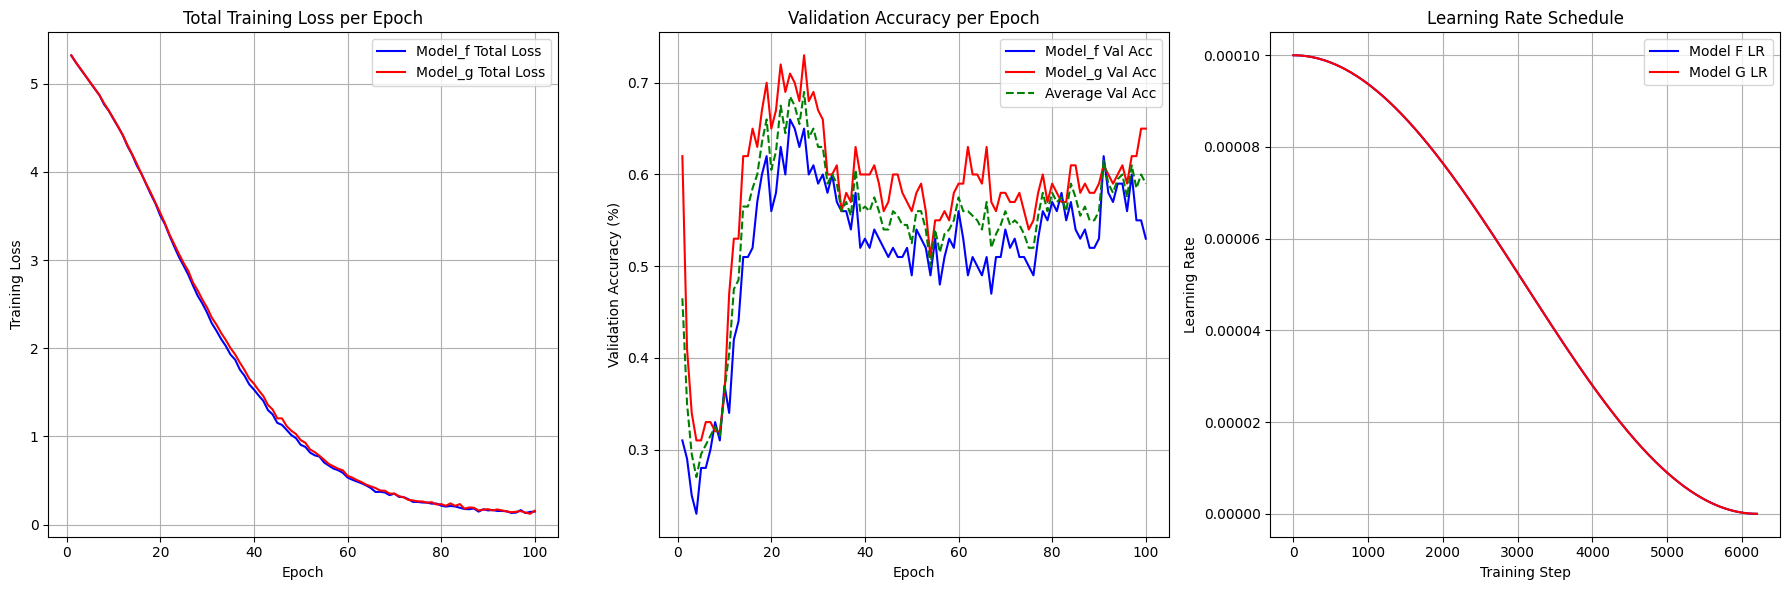

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(18, 6))

# Plot Total Training Losses
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_total_f, 'b-', label="Model_f Total Loss")
plt.plot(epochs, train_losses_total_g, 'r-', label="Model_g Total Loss")
# Optionally plot supervised/unsupervised components
# plt.plot(epochs, train_losses_sup_f, 'b--', label="Model_f Sup Loss")
# plt.plot(epochs, train_losses_unsup_f, 'b:', label="Model_f Unsup Loss")
# plt.plot(epochs, train_losses_sup_g, 'r--', label="Model_g Sup Loss")
# plt.plot(epochs, train_losses_unsup_g, 'r:', label="Model_g Unsup Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Total Training Loss per Epoch")
plt.legend()
plt.grid(True)

# Plot Validation Accuracies
plt.subplot(1, 3, 2)
plt.plot(epochs, [acc*100 for acc in val_accuracies_f], 'b-', label="Model_f Val Acc")
plt.plot(epochs, [acc*100 for acc in val_accuracies_g], 'r-', label="Model_g Val Acc")
plt.plot(epochs, [acc*100 for acc in val_accuracies_avg], 'g--', label="Average Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)

# Plot Learning Rate (Optional, assumes one optimizer group)
plt.subplot(1, 3, 3)
# Need to store LR history during training if using scheduler
lr_history_f = []
lr_history_g = []
# Example: Re-run scheduler steps to get history (not ideal, better to store during training)
if scheduler_f:
    temp_optimizer = optim.AdamW(model_f.parameters(), lr=LEARNING_RATE)
    temp_scheduler = optim.lr_scheduler.CosineAnnealingLR(temp_optimizer, T_max=len(labeled_loader) * NUM_EPOCHS)
    for _ in range(len(labeled_loader) * NUM_EPOCHS):
        lr_history_f.append(temp_optimizer.param_groups[0]['lr'])
        temp_scheduler.step()
    plt.plot(range(1, len(lr_history_f) + 1), lr_history_f, 'b-', label='Model F LR')

if scheduler_g:
    temp_optimizer = optim.AdamW(model_g.parameters(), lr=LEARNING_RATE)
    temp_scheduler = optim.lr_scheduler.CosineAnnealingLR(temp_optimizer, T_max=len(labeled_loader) * NUM_EPOCHS)
    for _ in range(len(labeled_loader) * NUM_EPOCHS):
        lr_history_g.append(temp_optimizer.param_groups[0]['lr'])
        temp_scheduler.step()
    plt.plot(range(1, len(lr_history_g) + 1), lr_history_g, 'r-', label='Model G LR')

plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 11. Final Evaluation (Using Best Models)

Load the best saved models and evaluate them individually and averaged on the validation set.

In [11]:
print("Loading best models for final evaluation...")

best_model_f_path = os.path.join(CHECKPOINT_DIR, "best_model_f.pt")
best_model_g_path = os.path.join(CHECKPOINT_DIR, "best_model_g.pt")

if os.path.exists(best_model_f_path) and os.path.exists(best_model_g_path):
    # Recreate model structures
    final_model_f = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes, pretrained=False)).to(device)
    final_model_g = CheckpointWrapper(get_efficientnet_model(num_classes=num_classes, pretrained=False)).to(device)
    
    # Load state dictionaries
    final_model_f.load_state_dict(torch.load(best_model_f_path))
    final_model_g.load_state_dict(torch.load(best_model_g_path))
    
    print("Evaluating Best Model F...")
    final_loss_f, final_acc_f = evaluate(final_model_f, val_loader, ce_loss)
    print(f"  Best Model F Val Loss: {final_loss_f:.4f}, Val Acc: {final_acc_f*100:.2f}%")
    
    print("Evaluating Best Model G...")
    final_loss_g, final_acc_g = evaluate(final_model_g, val_loader, ce_loss)
    print(f"  Best Model G Val Loss: {final_loss_g:.4f}, Val Acc: {final_acc_g*100:.2f}%")
    
    print(f"\nFinal Average Validation Accuracy (from epoch): {best_val_acc_avg*100:.2f}%")
    print(f"Final Average Validation Accuracy (re-evaluated): {(final_acc_f + final_acc_g)*100/2.0:.2f}%")
else:
    print("Best model checkpoints not found. Cannot perform final evaluation.")

Loading best models for final evaluation...
Loading efficientnet-b0 without pretrained weights...
Replaced final layer for 200 classes.
Loading efficientnet-b0 without pretrained weights...
Replaced final layer for 200 classes.
Evaluating Best Model F...


/tmp/ipykernel_19/2392778334.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model_f.load_state_dict(torch.load(best_model_f_path))
/tmp/ipykernel_19/2392778334.p

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Best Model F Val Loss: 5.9625, Val Acc: 0.65%
Evaluating Best Model G...


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

  Best Model G Val Loss: 5.7001, Val Acc: 0.73%

Final Average Validation Accuracy (from epoch): 0.69%
Final Average Validation Accuracy (re-evaluated): 0.69%
